# Initials

In [2]:
import os, os.path
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import glob
import pickle

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [3]:
place = 'local'

def vs_to_colab(place='local'):
    """This function is to set the path of the working place, depending if we are working online or local

    Args:
        place (str): Name of the place. Two options. Defaults to 'local'.
    """
    if (place=='local'):
        os.chdir('/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte_1')
    elif (place=='online'):
        os.chdir('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte_1')
    else:
        print('Not accepted working place, try again')
        
    return os.getcwd()

main_path = vs_to_colab(place='local')


# Functions and classes

In [4]:
class path_and_label:
    """This class is for storing paths and labels of all images in the dataset, for a given classification problem, set name and class name.
    """
    def __init__(self,classif,set_name,class_name) -> None:
        folder_path = main_path + f'/images/{classif}/{set_name}/{class_name}' #Go to folder
        self.paths = glob.glob(folder_path+ '/*.jpg') #Get paths
        self.labels = np.zeros(len(self.paths),dtype=np.uint8) #Define labels
        if class_name in ['nevus', 'mel']: #if belonging to label 1
            self.labels = self.labels + 1
        elif class_name in ['scc']: #if belonging to label 2
            self.labels = self.labels + 2

class path_holder:
    """The objects of this class will contain all the paths and labels.
    """
    def __init__(self) -> None:
        pass
    binary_train_nevus = path_and_label('binary','train','nevus') #Path and label of train nevus
    binary_train_others = path_and_label('binary','train','others') #Path and label of train others
    binary_val_nevus = path_and_label('binary','val','nevus') #Path and label of nevus others
    binary_val_others = path_and_label('binary','val','others') #Path and label of val others
    
    multi_train_bcc = path_and_label('3_classes','train','bcc') #Path and label of train nevus
    multi_train_mel = path_and_label('3_classes','train','mel') #Path and label of train nevus
    multi_train_scc = path_and_label('3_classes','train','scc') #Path and label of train nevus
    
    multi_val_bcc = path_and_label('3_classes','val','bcc') #Path and label of train nevus
    multi_val_mel = path_and_label('3_classes','val','mel') #Path and label of train nevus
    multi_val_scc = path_and_label('3_classes','val','scc') #Path and label of train nevus

# Main

In [5]:
vs_to_colab(place='local')
data = path_holder()

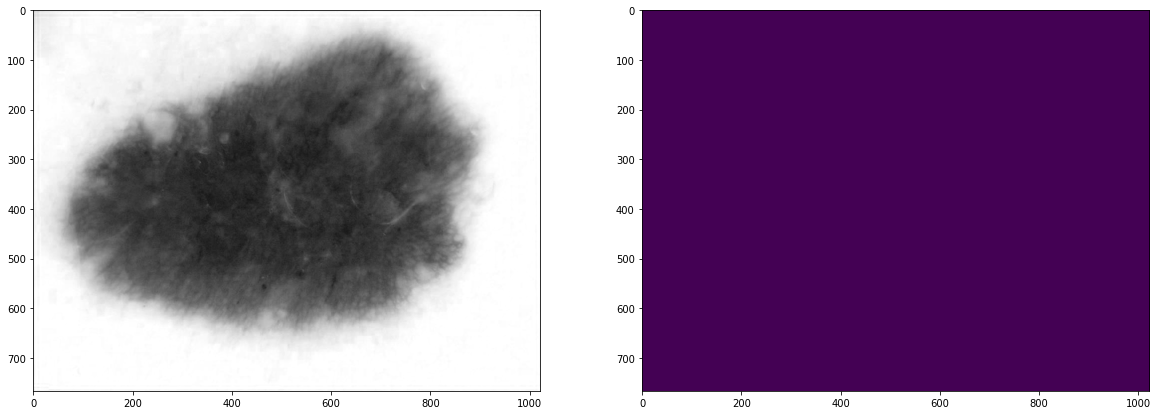

In [6]:
for i in range(60,61):

    im_path = data.binary_train_nevus.paths[i]

    im_bgr = cv.imread(im_path)
    im_rgb = cv.cvtColor(im_bgr, cv.COLOR_BGR2RGB)
    im_ch = im_rgb[:,:,2]
    hist, edges = np.histogram(im_ch, bins=256, range=(0,256))


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    axs[0].imshow(im_ch, cmap='gray', vmin=0, vmax=255)
    axs[1].imshow(im_ch<=10)


In [7]:
def color_hist_fv(im, bins):
    """Returns the feature vector as the concatenation of the color spaces histograms

    Args:
        im (array): Image in its channel representation, where te channel dimension is at the end.
        bins (int): number of bins. This also defines the feature vector size, combined with the channel num.
    """
    num_chs = im.shape[2]
    fv = np.zeros(256*num_chs, dtype=np.uint16)
    for ch in range(0,num_chs):
        im_ch = im[:,:,ch]
        hist, _ = np.histogram(im_ch.ravel(), bins=bins, range=(0,bins))
        fv[int(ch*fv.shape[0]/num_chs):int((ch+1)*fv.shape[0]/num_chs)] = hist
    
    return fv


In [9]:
# bins = 256
# num_chs = 3
# fv_all_pat = np.zeros((len(data.binary_val_others.paths),bins*num_chs),dtype=np.uint16) #all patients fvs matrix

# for i, path in enumerate(data.binary_val_others.paths):
#     im = cv.imread(path)
#     fv_all_pat[i,:] = color_hist_fv(im, bins)

# val_others_fv = fv_all_pat

# with open('color_val_others.p','wb') as handle:
#     pickle.dump(val_others_fv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('color_train_nevus.p', 'rb') as handle:
    train_nevus_fv = pickle.load(handle)

with open('color_train_others.p', 'rb') as handle:
    train_others_fv = pickle.load(handle)
    
with open('color_val_nevus.p', 'rb') as handle:
    val_nevus_fv = pickle.load(handle)
    
with open('color_val_others.p', 'rb') as handle:
    val_others_fv = pickle.load(handle)
    

with open('color_rgb_fv.p','wb') as handle:
    pickle.dump(val_others_fv, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
X_train = np.concatenate((train_nevus_fv,train_others_fv),axis=0)
y_train = np.concatenate((data.binary_train_nevus.labels, data.binary_train_others.labels),axis=0)
y_train.shape

(15195,)

In [ ]:
X_val = np.concatenate((val_nevus_fv,val_others_fv),axis=0)
y_val = np.concatenate((data.binary_val_nevus.labels, data.binary_val_others.labels),axis=0)
X_val.shape

(3796, 768)

In [ ]:
param_grid = {'classifier__n_estimators': [100, 200, 400, 600],}
pipe = Pipeline([('scaler', StandardScaler()),('classifier',RandomForestClassifier())])
grid = GridSearchCV(pipe, param_grid, verbose = 3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......classifier__n_estimators=100;, score=0.793 total time=  14.5s
[CV 2/5] END ......classifier__n_estimators=100;, score=0.800 total time=  14.8s
[CV 3/5] END ......classifier__n_estimators=100;, score=0.803 total time=  14.4s
[CV 4/5] END ......classifier__n_estimators=100;, score=0.790 total time=  14.6s
[CV 5/5] END ......classifier__n_estimators=100;, score=0.795 total time=  14.5s
[CV 1/5] END ......classifier__n_estimators=200;, score=0.796 total time=  28.5s
[CV 2/5] END ......classifier__n_estimators=200;, score=0.802 total time=  28.6s
[CV 3/5] END ......classifier__n_estimators=200;, score=0.804 total time=  28.7s
[CV 4/5] END ......classifier__n_estimators=200;, score=0.789 total time=  28.7s
[CV 5/5] END ......classifier__n_estimators=200;, score=0.797 total time=  28.6s
[CV 1/5] END ......classifier__n_estimators=400;, score=0.797 total time=  58.0s
[CV 2/5] END ......classifier__n_estimators=400;,

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
np.mean(y_pred == y_val)

0.8076923076923077